# DeltaSVM predictions of variant effects against MPRA data

We generate deltaSVM predictions for the genomic regions from [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w) and compare against the experimental data from MPRA assays reported there, using AUROC as a metric.

## Setup

### Imports

In [1]:
import duckdb
import pandas as pd
from pathlib import Path
from Bio.SeqIO import TwoBitIO

import sys
sys.path.append('..')

### Paths to data, models, etc

For deltaSVM, we will be using the two ENCODE3 models trained on K562, one for enhancers and one for promoters. See [corresponding Beer Lab website](https://www.beerlab.org/deltasvm_models/) for documentation and downloads. 

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = PROJECT_ROOT / 'SHARED'
DB_ROOT = PROJECT_ROOT / 'db'
MPRA_DATA_DIR = PROJECT_ROOT / 'benchmarks' / 'Kircher_et_al_2019'
GKSVM_MODEL_DIR = DATA_ROOT / 'trained-models' / 'deltaSVM'
GKSVM_MODELS = {
    'Enhancers': GKSVM_MODEL_DIR / 'DHS_E3_167_300_noproms_nc30_hg38_top10k_vs_neg1x_avg_weights.out',
    'Promoters': GKSVM_MODEL_DIR / 'DHS_E3_167_300_proms_hg38_top10k_vs_neg1x_avg_weights.out',
}
GKSVM_DATA_DIR = MPRA_DATA_DIR / '..' / 'MPRA-deltaSVM'

## Load MPRA data and extract regions

In [3]:
from starrutil.mprautil import read_kircher_mpra_data, get_kircher_mpra_regions
mpra_data = read_kircher_mpra_data(MPRA_DATA_DIR)
mpra_regions = get_kircher_mpra_regions(mpra_df=mpra_data)
kircher_nmut = len(mpra_data.select(['chrom', 'allele_pos', 'alt_allele']).unique().collect())
print(f"Total number of unique mutations: {kircher_nmut:,}")

Total number of unique mutations: 29,444


## Generate deltaSVM predictions

### Obtain genome for extending sequences for Kircher regions

DeltaSVM needs the SNV at the center of a sequence $k*2-1$ in length for a model with k-mers of length $k$. Hence, to include predictions for the first and last $k-1$ bases, we need to extend the region by the corresponding number of bases.

In [4]:
genome = TwoBitIO.TwoBitIterator('../../igvf-pm/hg38/hg38.2bit')

### Load pre-trained deltaSVM models

We will be using the ENCODE3 models trained on K562, one for enhancers and one for promoters.

In [5]:
from util.deltasvm import load_pretrained
gksvm_models = {k: load_pretrained(v) for k, v in GKSVM_MODELS.items()}
kmer_lengths = {k: len(next(iter(model))) for k, model in gksvm_models.items()}

### Generate predictions for each region

We will use the promoter model for promoter regions, and the enhancer model for enhancer regions, using saturated _in-silico_ mutagenesis.

In [6]:
from util.deltasvm import deltaSVM_saturated_mutations

In [7]:
deltasvm_df = None
for region in mpra_regions.itertuples():
    kmer_len = kmer_lengths[region.region_type]
    seq_from = region.start_pos - kmer_len + 1
    seq_to = region.end_pos + kmer_len
    seq = str(genome[region.chrom].seq[seq_from:seq_to].upper())
    mut_gen = deltaSVM_saturated_mutations(seq, model=gksvm_models[region.region_type], k=kmer_len,
                                           start_pos=seq_from,
                                           pos_col='allele_pos', ref_col='ref_allele', alt_col='alt_allele',
                                           score_col='log2fc')
    mut_df = pd.DataFrame(mut_gen)
    mut_df.insert(0, 'chrom', region.chrom)
    mut_df.insert(0, 'region', region.region)
    if deltasvm_df is None:
        deltasvm_df = mut_df
    else:
        deltasvm_df = pd.concat([deltasvm_df, mut_df], ignore_index=True)


Write predictions to TSV:

In [8]:
# deltasvm_df.to_csv(GKSVM_DATA_DIR / 'deltasvm_saturated_mutations.tsv', sep='\t', index=False)

### Join predicted effect sizes with MPRA data

In [9]:
from starrutil.mprautil import join_preds_to_mpra
deltasvm_data = join_preds_to_mpra(deltasvm_df, mpra_data)
print(f"Number of MPRA results matched with deltaSVM predictions: {len(deltasvm_data):,} ({len(deltasvm_data)/kircher_nmut:.1%})")

Number of MPRA results matched with deltaSVM predictions: 29,444 (100.0%)


Sanity check for whether any reference alleles don't match:

In [10]:
deltasvm_data.loc[deltasvm_data['ref_allele'] != deltasvm_data['pred_ref_allele']]

,region_type,region,chrom,allele_pos,ref_allele,pred_ref_allele,alt_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags,mpra_experiment


## Add labels for positive and negative classes

In [11]:
from starrutil.mprautil import add_class_labels

In [12]:
Pval_pos = 1e-5
Pval_neg = 1e-5 # 0.01
effect_neg = 0.05
pos_label = f"MPRA p≤{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"

Compute and assign labels, obtain counts for each class, both for enhancers and promoters:

In [13]:
deltasvm_df_roc = add_class_labels(
    deltasvm_data,
    Pval_pos=Pval_pos,
    Pval_neg=Pval_neg,
    abs_effect_neg=effect_neg,
    pos_label=pos_label, 
    neg_label=neg_label
).dropna(subset=['label'])
deltasvm_df_roc.groupby(['region_type','label'])['chrom'].count()

region_type  label       
Enhancers    MPRA p>1e-05    7237
             MPRA p≤1e-05    2772
Promoters    MPRA p>1e-05    3418
             MPRA p≤1e-05    1987
Name: chrom, dtype: int64

## DeltaSVM vs MPRA effect sizes

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'DeltaSVM predicted vs MPRA effect size')

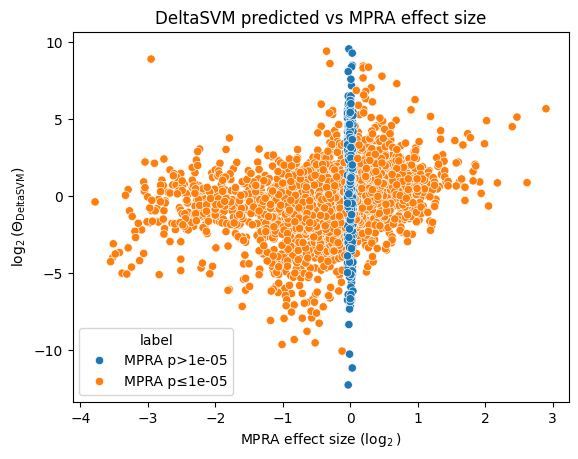

In [15]:
ax = sns.scatterplot(data=deltasvm_df_roc,
                     x='mpra_max_log2effect', y='log2FC',
                     hue='label')
ax.set(xlabel='MPRA effect size ($\log_2)$', ylabel='$\log_2(\Theta_{\mathrm{DeltaSVM}})$')
ax.set_title('DeltaSVM predicted vs MPRA effect size')

## AUROCs for predicted effect sizes

In [16]:
from starrutil.roc import roc_topN

  AUCs:
    All data = 0.545
    Top 1000 = 0.598
    Top  500 = 0.600
    Top  200 = 0.595


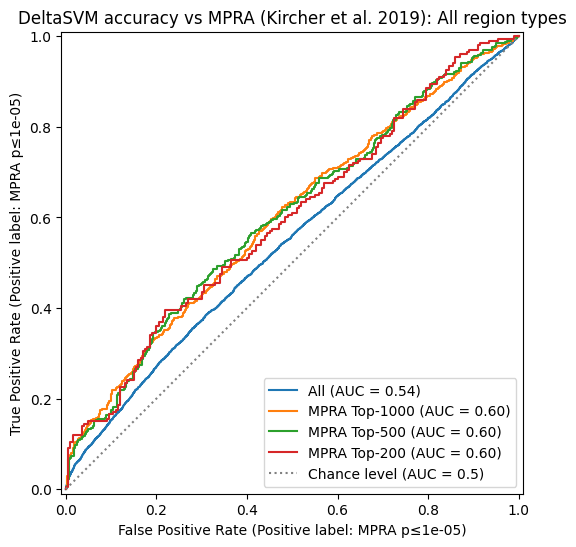

In [17]:
rocs, ax = roc_topN(deltasvm_df_roc, pos_label=pos_label, neg_label=neg_label, random_state=42)
_ = ax.set_title('DeltaSVM accuracy vs MPRA (Kircher et al. 2019): All region types')

Region type: Enhancers
  AUCs:
    All data = 0.543
    Top 1000 = 0.577
    Top  500 = 0.585
    Top  200 = 0.597
Region type: Promoters
  AUCs:
    All data = 0.556
    Top 1000 = 0.620
    Top  500 = 0.653
    Top  200 = 0.655


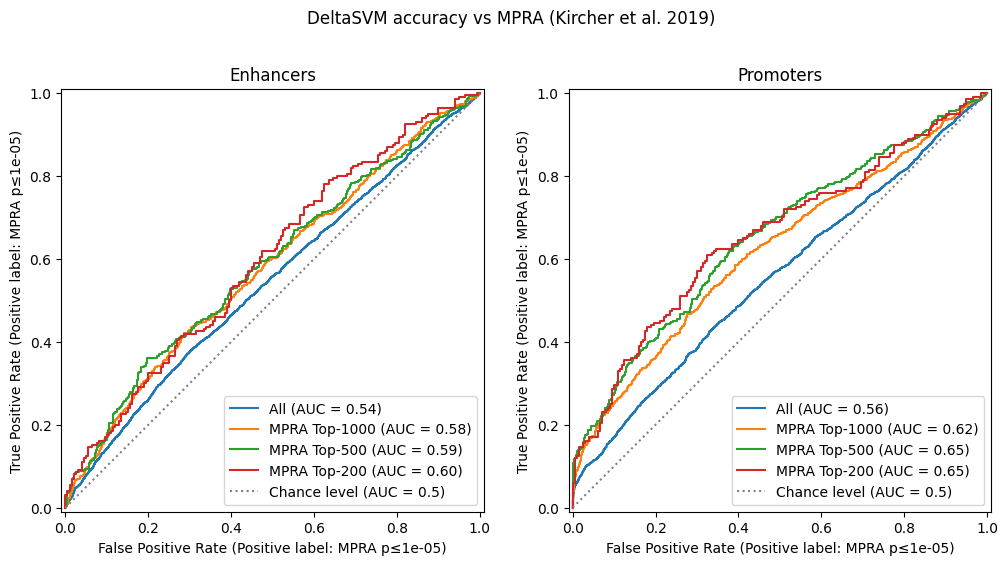

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, region_type in enumerate(['Enhancers', 'Promoters']):
    df = deltasvm_df_roc.loc[deltasvm_df_roc['region_type'] == region_type]
    print(f"Region type: {region_type}")
    _, ax = roc_topN(df, neg_label=neg_label, pos_label=pos_label, ax=axs[i])
    ax.set_title(f'{region_type}')
_ = fig.suptitle('DeltaSVM accuracy vs MPRA (Kircher et al. 2019)')